# Dec ??th, 2022 (AD: full brain)

**Motivation**: save both run and session level <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
from register.register import Register, reset_ants_img
from sklearn.cluster import KMeans

mice = Mice(512)
mice.set_band(band_bo=(0.008,0.28))
reg = Register(mice)

In [3]:
roi = np.load(pjoin(tmp_dir, 'ROI_SanDiego.npy'))

In [4]:
regions = []
for lbl in mice.node_lookup['ca2'].values():
    r = mice.parcel.encode(lbl)
    if not (roi == r).sum():
        continue
    regions.append(r)
regions = np.array(regions)
node2region = {
    n: r for n, r in
    enumerate(regions)
}
len(node2region)

532

In [5]:
bs = Base(mice, mode='ca2')
bs.n2l = {
    n: '-'.join(map(lambda x: str(x), mice.parcel.decode(r).ravel()))
    for n, r in node2region.items()
}

## Get files, xtract

In [6]:
files = sorted(filter(
    lambda f: 'sub-DKI' in f or 'sub-WT'in f,
    os.listdir(mice.cfg.raw_dir),
))
len(files)

348

In [7]:
data_all = {}
for f in tqdm(files):
    x = ants.image_read(pjoin(mice.cfg.raw_dir, f)).numpy()
    data = np_nans((len(node2region), x.shape[-1]))
    for n, r in node2region.items():
        m = roi == r
        if m.sum() == 0:
            continue
        y = x[m].mean(0)
        if y.std() == 0:
            continue
        data[n] = y
    key = '_'.join(f.split('_')[:3])
    data_all[key] = data

  0%|          | 0/348 [00:00<?, ?it/s]

## Mega animal?

In [8]:
mega = {
    g: np.concatenate([
        x for _, x in filter(lambda tup: g in tup[0], data_all.items())
    ], -1) for g in ['DKI', 'WT']
}
{k: v.shape for k, v in mega.items()}

{'DKI': (532, 66239), 'WT': (532, 37141)}

In [9]:
a_mega_dki, _ = get_adj_mat(mega['DKI'], 'pearson', p_val=1)
a_mega_wt, _ = get_adj_mat(mega['WT'], 'pearson', p_val=1)
delta = (a_mega_wt - a_mega_dki) / np.maximum(a_mega_wt, 1e-8)

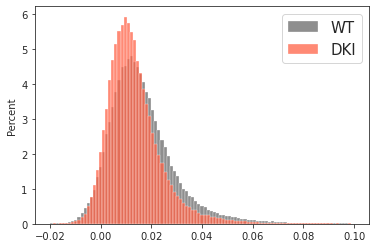

In [10]:
sns.histplot(a_mega_wt[a_mega_wt.nonzero()], color='dimgrey',
             label='WT', bins=np.linspace(-0.02, 0.1, 100), stat='percent')
sns.histplot(a_mega_dki[a_mega_dki.nonzero()], color='tomato',
             label='DKI', bins=np.linspace(-0.02, 0.1, 100), stat='percent')
plt.legend(fontsize=15)
plt.show()

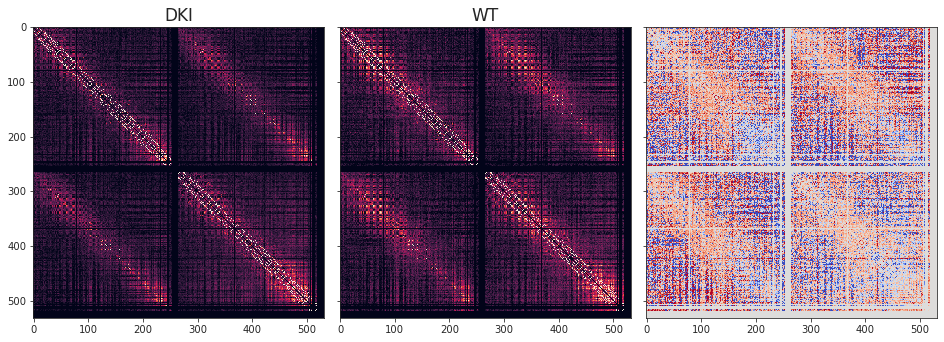

In [11]:
fig, axes = create_figure(1, 3, (13, 4.5), 'all', 'all', constrained_layout=True)
axes[0].imshow(a_mega_dki, vmin=0, vmax=0.1)
axes[1].imshow(a_mega_wt, vmin=0, vmax=0.1)
axes[2].imshow(delta, cmap='coolwarm', vmin=-1, vmax=1)

axes[0].set_title('DKI', fontsize=17)
axes[1].set_title('WT', fontsize=17)
plt.show()

In [12]:
num_k = 6
km_dki = KMeans(n_clusters=num_k, random_state=0).fit(a_mega_dki)
km_wt = KMeans(n_clusters=num_k, random_state=0).fit(a_mega_wt)
partition_dki = km_dki.labels_ + 1
partition_wt = km_wt.labels_ + 1

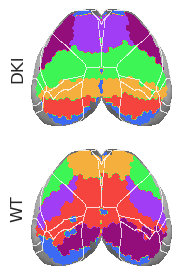

In [13]:
_ = bs.show({
    'DKI': partition_dki,
    'WT': partition_wt},
    cmap=get_cluster_cmap(range(num_k)),
    vmin=None,
    vmax=None,
    interpolation='none',
)

In [17]:
def _adj2graph(adj):
    a = adj.copy()
    a[np.isnan(a)] = 0
    return nx.from_numpy_array(a)

In [18]:
perc = 15

for key, a in {'sub-DKI': a_mega_dki, 'sub-WT': a_mega_wt}.items():
    th = calculate_threshold(a, perc / 100, verbose=True).pop()
    a_final = dc(a)
    a_final[a <= th] = 0
    g = _adj2graph(a_final)

    path = f'n-512*3_bp(0.008,0.28)_bold-lite_rest_pearson_{key}'
    path = pjoin(mice.cfg.svinet_dir, path, 'real')
    print(path)
    save_graph(g, perc, path, 100, verbose=True)

threshold = 0.023   /   density:  requested = 0.15000, result = 0.15000;

/home/hadi/Documents/workspaces/svinet/n-512*3_bp(0.008,0.28)_bold-lite_rest_pearson_sub-DKI/
real

[PROGRESS] 'p15-binary.txt' saved at
/home/hadi/Documents/workspaces/svinet/n-512*3_bp(0.008,0.28)_bold-lite_rest_pearson_sub-DKI/
real/p15-binary

[PROGRESS] 'p15-sample.txt' saved at
/home/hadi/Documents/workspaces/svinet/n-512*3_bp(0.008,0.28)_bold-lite_rest_pearson_sub-DKI/
real/p15-sample

threshold = 0.029   /   density:  requested = 0.15000, result = 0.15000;

/home/hadi/Documents/workspaces/svinet/n-512*3_bp(0.008,0.28)_bold-lite_rest_pearson_sub-WT/r
eal

[PROGRESS] 'p15-binary.txt' saved at
/home/hadi/Documents/workspaces/svinet/n-512*3_bp(0.008,0.28)_bold-lite_rest_pearson_sub-WT/r
eal/p15-binary

[PROGRESS] 'p15-sample.txt' saved at
/home/hadi/Documents/workspaces/svinet/n-512*3_bp(0.008,0.28)_bold-lite_rest_pearson_sub-WT/r
eal/p15-sample

### SVINET (mega)

In [20]:
num_k = 7
kwargs = {
    'mice': mice,
    'num_k': num_k,
    'perc': 'p15-sample',
    'mode': 'bold-lite',
    'verbpose': True,
}

In [22]:
sv = SVINET(key='sub-DKI', **kwargs)
sv.n2l = {
    n: '-'.join(map(
        lambda x: str(x),
        mice.parcel.decode(r).ravel()
    )) for n, r in node2region.items()
}
_ = sv.load_runs()
_ = sv.fit_svinet()

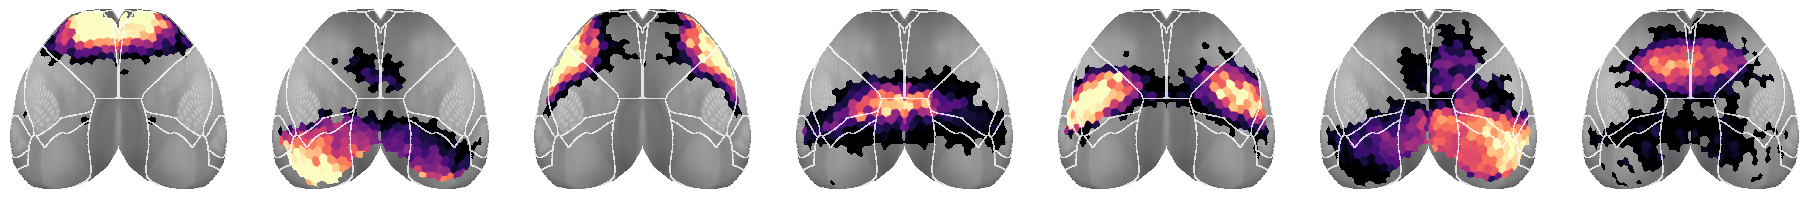

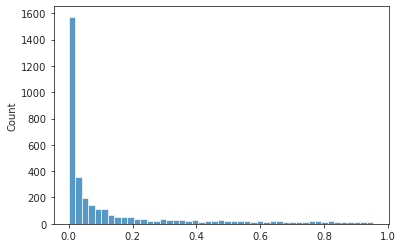

In [27]:
_ = bs.show(sv.pi, vmin=0.1, vmax=0.8, mask_thresh=0.05)
sns.histplot(sv.pi.ravel());

In [28]:
sv = SVINET(key='sub-WT', **kwargs)
sv.n2l = {
    n: '-'.join(map(
        lambda x: str(x),
        mice.parcel.decode(r).ravel()
    )) for n, r in node2region.items()
}
_ = sv.load_runs()
_ = sv.fit_svinet()

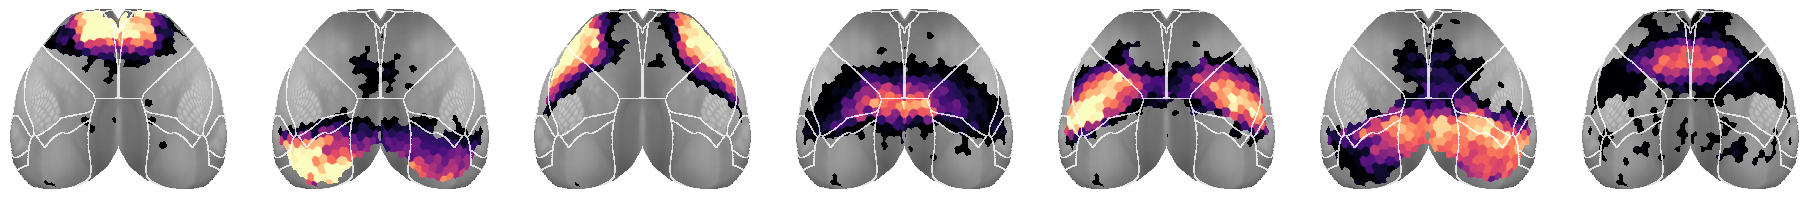

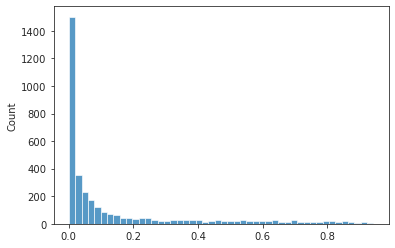

In [29]:
_ = bs.show(sv.pi, vmin=0.1, vmax=0.8, mask_thresh=0.05)
sns.histplot(sv.pi.ravel());

## Now each run

In [91]:
adj = {}
for key, data in tqdm(data_all.items()):
    adj[key] = get_adj_mat(data, 'pearson', p_val=1)[0]

  0%|          | 0/348 [00:00<?, ?it/s]

In [92]:
a_dki = [
    np.expand_dims(a, 0) for k, a
    in adj.items() if 'DKI' in k
]
a_wt = [
    np.expand_dims(a, 0) for k, a
    in adj.items() if 'WT' in k
]
a_dki = np.concatenate(a_dki)
a_wt = np.concatenate(a_wt)
a_dki.shape, a_wt.shape

((223, 532, 532), (125, 532, 532))

In [97]:
a_avg_dki = np.nanmean(a_dki, 0)
a_avg_wt = np.nanmean(a_wt, 0)
delta = (a_avg_wt - a_avg_dki) / np.maximum(a_avg_wt, 1e-8)

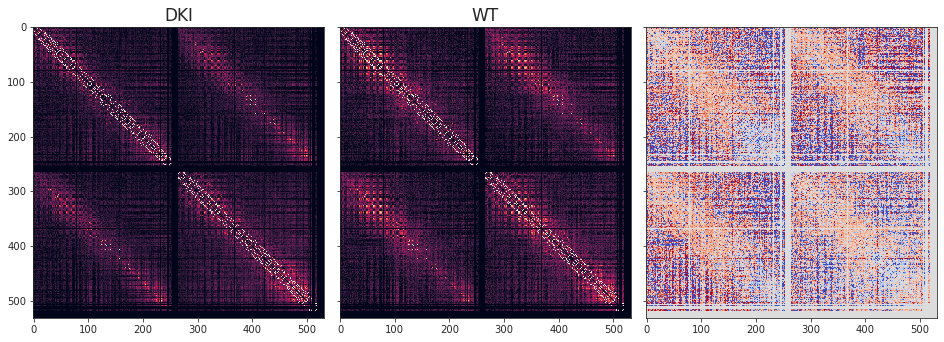

In [98]:
fig, axes = create_figure(1, 3, (13, 4.5), 'all', 'all', constrained_layout=True)
axes[0].imshow(a_avg_dki, vmin=0, vmax=0.1)
axes[1].imshow(a_avg_wt, vmin=0, vmax=0.1)
axes[2].imshow(delta, cmap='coolwarm', vmin=-1, vmax=1)

axes[0].set_title('DKI', fontsize=17)
axes[1].set_title('WT', fontsize=17)
plt.show()

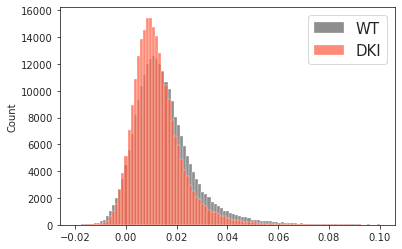

In [100]:
sns.histplot(a_avg_wt[a_avg_wt.nonzero()], color='dimgrey', label='WT', bins=np.linspace(-0.02, 0.1, 100))
sns.histplot(a_avg_dki[a_avg_dki.nonzero()], color='tomato', label='DKI', bins=np.linspace(-0.02, 0.1, 100))
plt.legend(fontsize=15)
plt.show()

In [101]:
from sklearn.cluster import KMeans

num_k = 6
km_dki = KMeans(n_clusters=num_k, random_state=0).fit(a_avg_dki)
km_wt = KMeans(n_clusters=num_k, random_state=0).fit(a_avg_wt)
partition_dki = km_dki.labels_ + 1
partition_wt = km_wt.labels_ + 1

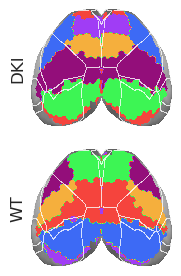

In [102]:
cmap = get_cluster_cmap(range(num_k))
_ = bs.show({
    'DKI': partition_dki,
    'WT': partition_wt},
    cmap=cmap,
    vmin=None,
    vmax=None,
    interpolation='none',
)

In [103]:
list(adj)

[
    'sub-DKI01_ses-1_run-1',
    'sub-DKI01_ses-1_run-2',
    'sub-DKI01_ses-1_run-3',
    'sub-DKI02_ses-1_run-1',
    'sub-DKI02_ses-1_run-2',
    'sub-DKI02_ses-1_run-3',
    'sub-DKI02_ses-2_run-1',
    'sub-DKI02_ses-2_run-2',
    'sub-DKI02_ses-2_run-3',
    'sub-DKI03_ses-1_run-1',
    'sub-DKI03_ses-1_run-2',
    'sub-DKI03_ses-1_run-3',
    'sub-DKI04_ses-1_run-1',
    'sub-DKI04_ses-1_run-2',
    'sub-DKI04_ses-1_run-3',
    'sub-DKI04_ses-2_run-1',
    'sub-DKI04_ses-2_run-2',
    'sub-DKI04_ses-2_run-3',
    'sub-DKI05_ses-1_run-1',
    'sub-DKI05_ses-1_run-2',
    'sub-DKI05_ses-1_run-3',
    'sub-DKI06_ses-1_run-1',
    'sub-DKI06_ses-1_run-2',
    'sub-DKI06_ses-1_run-3',
    'sub-DKI06_ses-2_run-1',
    'sub-DKI06_ses-2_run-2',
    'sub-DKI06_ses-2_run-3',
    'sub-DKI07_ses-1_run-1',
    'sub-DKI07_ses-1_run-2',
    'sub-DKI07_ses-1_run-3',
    'sub-DKI07_ses-2_run-1',
    'sub-DKI07_ses-2_run-2',
    'sub-DKI07_ses-2_run-3',
    'sub-DKI08_ses-1_run-1',
    'sub-DKI08_ses-1_run-2',
    'sub-DKI08_ses-1_run-3',
    'sub-DKI09_ses-1_run-1',
    'sub-DKI09_ses-1_run-2',
    'sub-DKI09_ses-1_run-3',
    'sub-DKI09_ses-2_run-1',
    'sub-DKI09_ses-2_run-2',
    'sub-DKI09_ses-2_run-3',
    'sub-DKI09_ses-3_run-1',
    'sub-DKI09_ses-3_run-2',
    'sub-DKI09_ses-3_run-3',
    'sub-DKI10_ses-1_run-1',
    'sub-DKI10_ses-1_run-2',
    'sub-DKI10_ses-1_run-3',
    'sub-DKI10_ses-2_run-1',
    'sub-DKI10_ses-2_run-2',
    'sub-DKI10_ses-2_run-3',
    'sub-DKI10_ses-3_run-1',
    'sub-DKI10_ses-3_run-2',
    'sub-DKI10_ses-3_run-3',
    'sub-DKI11_ses-1_run-1',
    'sub-DKI11_ses-1_run-2',
    'sub-DKI11_ses-1_run-3',
    'sub-DKI11_ses-2_run-1',
    'sub-DKI11_ses-2_run-2',
    'sub-DKI11_ses-2_run-3',
    'sub-DKI11_ses-3_run-1',
    'sub-DKI11_ses-3_run-2',
    'sub-DKI11_ses-3_run-3',
    'sub-DKI12_ses-1_run-1',
    'sub-DKI12_ses-1_run-2',
    'sub-DKI12_ses-1_run-3',
    'sub-DKI12_ses-2_run-1',
    'sub-DKI12_ses-2_run-2',
    'sub-DKI12_ses-2_run-3',
    'sub-DKI12_ses-3_run-1',
    'sub-DKI12_ses-3_run-2',
    'sub-DKI12_ses-3_run-3',
    'sub-DKI13_ses-1_run-1',
    'sub-DKI13_ses-1_run-2',
    'sub-DKI13_ses-1_run-3',
    'sub-DKI14_ses-1_run-1',
    'sub-DKI14_ses-1_run-2',
    'sub-DKI14_ses-1_run-3',
    'sub-DKI14_ses-3_run-1',
    'sub-DKI14_ses-3_run-2',
    'sub-DKI14_ses-3_run-3',
    'sub-DKI15_ses-1_run-1',
    'sub-DKI15_ses-1_run-2',
    'sub-DKI15_ses-1_run-3',
    'sub-DKI15_ses-3_run-1',
    'sub-DKI15_ses-3_run-2',
    'sub-DKI15_ses-3_run-3',
    'sub-DKI16_ses-3_run-1',
    'sub-DKI16_ses-3_run-2',
    'sub-DKI17_ses-3_run-1',
    'sub-DKI17_ses-3_run-2',
    'sub-DKI17_ses-3_run-3',
    'sub-DKI18_ses-3_run-1',
    'sub-DKI18_ses-3_run-2',
    'sub-DKI18_ses-3_run-3',
    'sub-DKI19_ses-3_run-1',
    'sub-DKI19_ses-3_run-2',
    'sub-DKI19_ses-3_run-3',
    'sub-DKI20_ses-3_run-1',
    'sub-DKI20_ses-3_run-2',
    'sub-DKI20_ses-3_run-3',
    'sub-DKI21_ses-2_run-1',
    'sub-DKI21_ses-2_run-2',
    'sub-DKI21_ses-2_run-3',
    'sub-DKI22_ses-5_run-1',
    'sub-DKI22_ses-5_run-2',
    'sub-DKI22_ses-5_run-3',
    'sub-DKI22_ses-6_run-1',
    'sub-DKI22_ses-6_run-2',
    'sub-DKI22_ses-6_run-3',
    'sub-DKI23_ses-5_run-1',
    'sub-DKI23_ses-5_run-2',
    'sub-DKI23_ses-5_run-3',
    'sub-DKI23_ses-6_run-1',
    'sub-DKI23_ses-6_run-2',
    'sub-DKI23_ses-6_run-3',
    'sub-DKI24_ses-5_run-1',
    'sub-DKI24_ses-5_run-2',
    'sub-DKI24_ses-5_run-3',
    'sub-DKI24_ses-6_run-1',
    'sub-DKI24_ses-6_run-2',
    'sub-DKI24_ses-6_run-3',
    'sub-DKI25_ses-5_run-1',
    'sub-DKI25_ses-5_run-2',
    'sub-DKI25_ses-5_run-3',
    'sub-DKI25_ses-6_run-1',
    'sub-DKI25_ses-6_run-2',
    'sub-DKI25_ses-6_run-3',
    'sub-DKI26_ses-5_run-1',
    'sub-DKI26_ses-5_run-2',
    'sub-DKI26_ses-6_run-1',
    'sub-DKI26_ses-6_run-2',
    'sub-DKI26_ses-6_run-3',
    'sub-DKI27_ses-5_run-1',
    'sub-DKI27_ses-5_run-2',
    'sub-DKI27_ses-5_run-3',
    'sub-DKI27_ses-6_run-1',
    'sub-DKI27_ses-6_run-

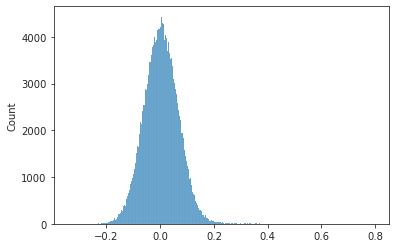

In [104]:
key = 'sub-DKI04_ses-1_run-3'
a = adj[key]
sns.histplot(a[a != 0]);

In [105]:
th = calculate_threshold(a, 0.15, verbose=True).pop()
a_bin = dc(a)
a_bin[a <= th] = 0
a_bin[a > th] = 1

threshold = 0.070   /   density:  requested = 0.15000, result = 0.15000;

In [106]:
nan = np.isnan(a_bin).sum(0) == len(a_bin)
zero = np.nanmean(np.abs(a_bin), 0) == 0
good = np.logical_and(~nan, ~zero)
adj_eff = a_bin[good][:, good]

adj_eff.shape, nan.sum(), zero.sum()

((494, 494), 0, 38)

In [107]:
def _adj2graph(adj):
    a = adj.copy()
    a[np.isnan(a)] = 0
    g = nx.from_numpy_array(a)
    return g

In [109]:
a_final = dc(a)
a_final[a <= th] = 0
g = _adj2graph(a_final)

<matplotlib.image.AxesImage object at 0x7f1380834a60>

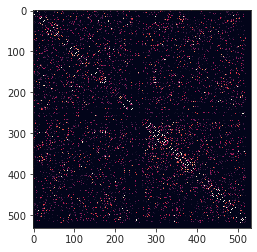

In [111]:
aaa = nx.adjacency_matrix(g).toarray()
plt.imshow(aaa, vmin=th, vmax=0.2)

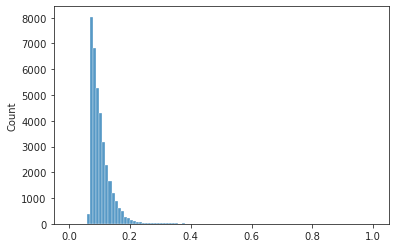

In [112]:
sns.histplot(aaa[aaa != 0], bins=np.linspace(0, 1, 101));

In [113]:
aaa.shape

(532, 532)

In [114]:
path = f'n-512*3_bp(0.008,0.28)_bold-lite_rest_pearson_{key}'
path = pjoin(mice.cfg.svinet_dir, path, 'real')
path

'/home/hadi/Documents/workspaces/svinet/n-512*3_bp(0.008,0.28)_bold-lite_rest_pearson_sub-DKI04_ses-1_run-3/real'

In [115]:
save_graph(g, 15, path, 10, verbose=True)

[PROGRESS] 'p15-binary.txt' saved at
/home/hadi/Documents/workspaces/svinet/n-512*3_bp(0.008,0.28)_bold-lite_rest_pearson_sub-DKI0
4_ses-1_run-3/real/p15-binary

[PROGRESS] 'p15-sample.txt' saved at
/home/hadi/Documents/workspaces/svinet/n-512*3_bp(0.008,0.28)_bold-lite_rest_pearson_sub-DKI0
4_ses-1_run-3/real/p15-sample

In [116]:
os.listdir(path)

['p15-binary', 'p15-sample']

### Loop (save graph)

In [119]:
def _adj2graph(adj):
    a = adj.copy()
    a[np.isnan(a)] = 0
    return nx.from_numpy_array(a)

In [133]:
%%time

perc = 15
threshold_all = {}
for key, a in adj.items():
    th = calculate_threshold(a, perc / 100, verbose=False).pop()
    threshold_all[key] = th
    a_final = dc(a)
    a_final[a <= th] = 0
    g = _adj2graph(a_final)
    
    path = f'n-512*3_bp(0.008,0.28)_bold-lite_rest_pearson_{key}'
    path = pjoin(mice.cfg.svinet_dir, path, 'real')
    save_graph(g, perc, path, 10, verbose=False)

CPU times: user 1min 52s, sys: 445 ms, total: 1min 53s
Wall time: 1min 53s


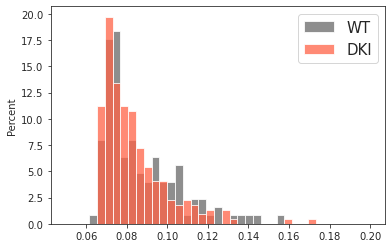

In [134]:
sns.histplot(
    [v for k, v in threshold_all.items() if 'WT' in k],
    color='dimgrey', label='WT', bins=np.linspace(0.05, 0.2, 40), stat='percent')
sns.histplot(
    [v for k, v in threshold_all.items() if 'DKI' in k],
    color='tomato', label='DKI', bins=np.linspace(0.05, 0.2, 40), stat='percent')
plt.legend(fontsize=15)
plt.show()

#### Now running this:

time ./loop_svinet.sh 512 3 7 p15-sample 500 bold-lite rest "0.008,0.28" pearson "sub[-_0-9a-zA-Z]*"

## SVINET

In [34]:
cnt = []
for f in sorted(os.listdir(mice.cfg.svinet_dir)):
    files = pjoin(mice.cfg.svinet_dir, f, 'real', 'p15-sample')
    files = sorted(os.listdir(files))
    cnt.append(len(files) - 1)
cnt = collections.Counter(cnt)
cnt

Counter({500: 350})

In [35]:
num_k = 7
kwargs = {
    'mice': mice,
    'num_k': num_k,
    'perc': 'p15-sample',
    'mode': 'bold-lite',
    'verbpose': True,
}

In [222]:
%%time

for f in tqdm(sorted(os.listdir(mice.cfg.svinet_dir))):
    key = '_'.join(f.split('_')[-3:])
    if 'pearson' in key:
        continue
    sv = SVINET(key=key, **kwargs)
    sv.n2l = {
        n: '-'.join(map(
            lambda x: str(x),
            mice.parcel.decode(r).ravel()
        )) for n, r in node2region.items()
    }
    _ = sv.load_runs()
    _ = sv.fit_svinet()

  0%|          | 0/348 [00:00<?, ?it/s]

CPU times: user 3h 59min 31s, sys: 7min 44s, total: 4h 7min 16s
Wall time: 58min 19s


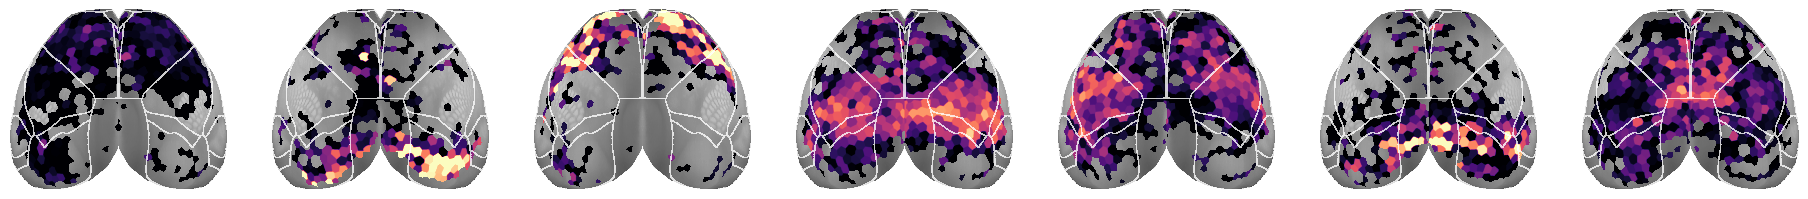

In [223]:
_ = sv.show(sv.pi, vmin=0.1, vmax=0.6, mask_thresh=0.05)

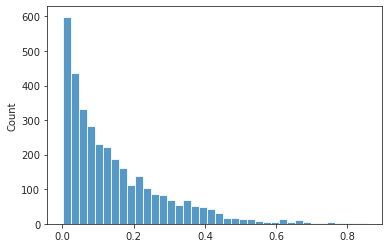

In [225]:
sns.histplot(sv.pi.ravel());

In [40]:
%%time

gam_all = collections.defaultdict(list)
for f in sorted(os.listdir(mice.cfg.svinet_dir)):
    key = '_'.join(f.split('_')[-3:])
    if 'pearson' in key:
        continue
    sv = SVINET(
        key=key,
        **kwargs,
    ).load_results()
    
    g = re.findall(
        r"[a-zA-Z]+",
        key.split('_')[0].split('-')[1],
    ).pop()
    gam_all[g].append(sv.gam_all)

CPU times: user 38.4 s, sys: 341 ms, total: 38.8 s
Wall time: 38.8 s


In [46]:
props = {
    'mice': mice,
    'perc': 'p15-sample',
    'num_k': num_k,
    'mode': 'bold-lite',
    'task': 'rest',
    'metric': 'pearson',
    'match_metric': 'euclidean',
    'match_using': 'gam',
    'graph_type': 'real',
    'dist_metric': 'cosine',
    'ordering': 'infer',
    'verbose': True,
}
self = Group(**props)
self.kw_kmeans = {'n_init': 10, 'max_iter': 300, 'tol': 0.0001}
self.n2l = {
    n: '-'.join(map(
        lambda x: str(x),
        mice.parcel.decode(r).ravel()
    )) for n, r in node2region.items()
}

### DKI

In [95]:
data = np.concatenate([x.reshape(-1, len(self.n2l)) for x in gam_all['DKI']])
data.shape

(780465, 532)

In [96]:
nonan = np.where(np.isnan(data).sum(0) == 0)[0]
len(nonan)

473

In [97]:
%%time

centroids = np.zeros((self.num_k, data.shape[-1]))
_centroids, _ = fit_kmeans(
    data=data[:, nonan],
    n_clusters=self.num_k,
    match_metric=self.sv_props['match_metric'],
    random_state=self.mice.cfg.random_state,
    kw_kmeans=self.kw_kmeans,
)
centroids = np.zeros((self.num_k, data.shape[-1]))
centroids[:, nonan] = _centroids

CPU times: user 1h 32min 38s, sys: 46.8 s, total: 1h 33min 24s
Wall time: 2min 41s


In [98]:
global_mapping = self.align_centroid_to_structs(
    pi_mv=centroids,
    metric='cosine',
    global_order=False,
)
centroids = centroids[global_mapping]
ner = Normalizer()

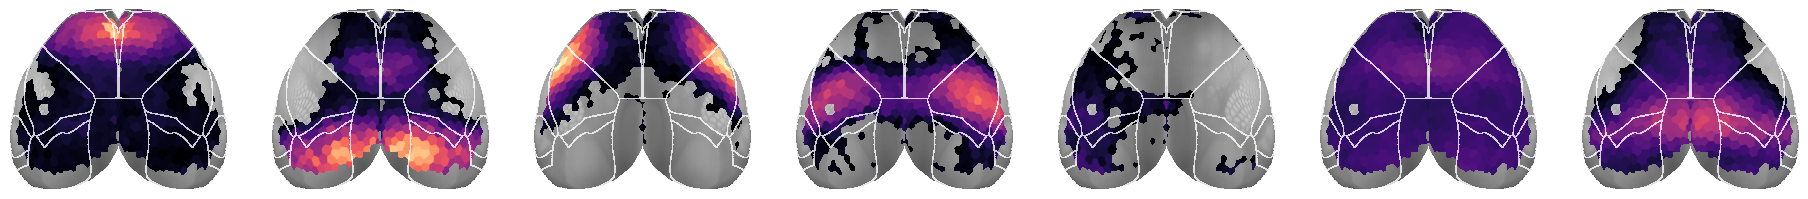

In [99]:
pi = centroids / np.nansum(centroids, -2, keepdims=True)
_ = self.show(pi, vmin=0.1, vmax=0.4, mask_thresh=0.1)

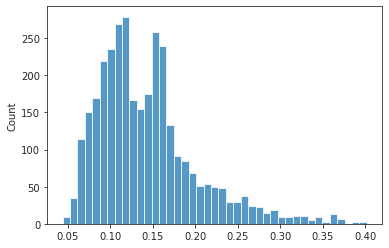

In [100]:
sns.histplot(pi.ravel());

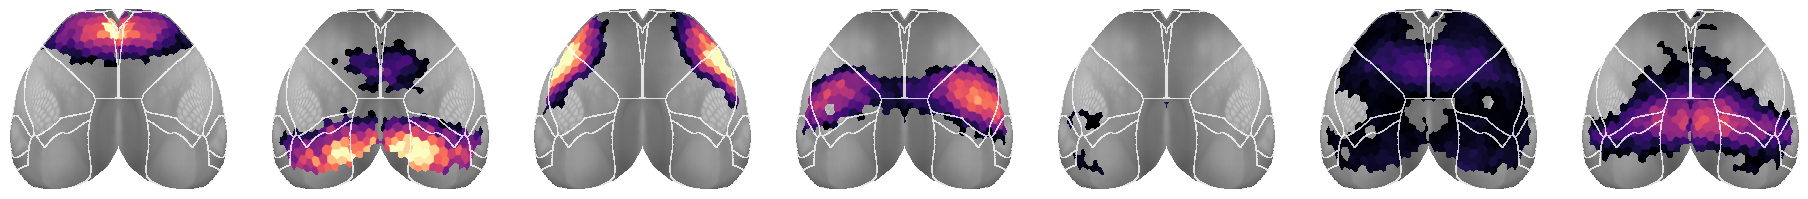

In [101]:
_ = self.show(pi, vmin=0.15, vmax=0.35, mask_thresh=0.15)

In [102]:
%%time

final = []
for f in tqdm(sorted(os.listdir(mice.cfg.svinet_dir))):
    key = '_'.join(f.split('_')[-3:])
    if 'pearson' in key:
        continue
    g = re.findall(
        r"[a-zA-Z]+",
        key.split('_')[0].split('-')[1],
    ).pop()
    if g != 'DKI':
        continue
    sv = SVINET(
        key=key,
        **kwargs,
    ).load_results()
    
    good = np.where(np.isnan(sv.gam).sum(0) == 0)[0]
    good = set(good).intersection(nonan)
    good = np.array(sorted(good))
    _x = sv.gam_all[..., good]
    _x = np.where(~np.isnan(_x), _x, 0.0)
    data_clean = {
        i: ner.fit_transform(_x[i])
        for i in range(len(_x))
    }
    perms =  find_best_mappings(
        data=data_clean,
        centroids=ner.fit_transform(centroids[:, good]),
        match_metric=self.align_metric,
        global_order=self.global_order,
    )
    x = np_nans(sv.gam_all.shape)
    for seed, p in perms.items():
        x[seed] = sv.gam_all[seed][list(p.values())]
    final.append(np.expand_dims(avg(x), 0))
final = np.concatenate(final)
final.shape

  0%|          | 0/350 [00:00<?, ?it/s]

CPU times: user 1min 23s, sys: 541 ms, total: 1min 23s
Wall time: 1min 23s


(223, 7, 532)

In [103]:
pi_dki = avg(final)
pi_dki /= np.nansum(pi_dki, -2, keepdims=True)
pi_dki.shape

(7, 532)

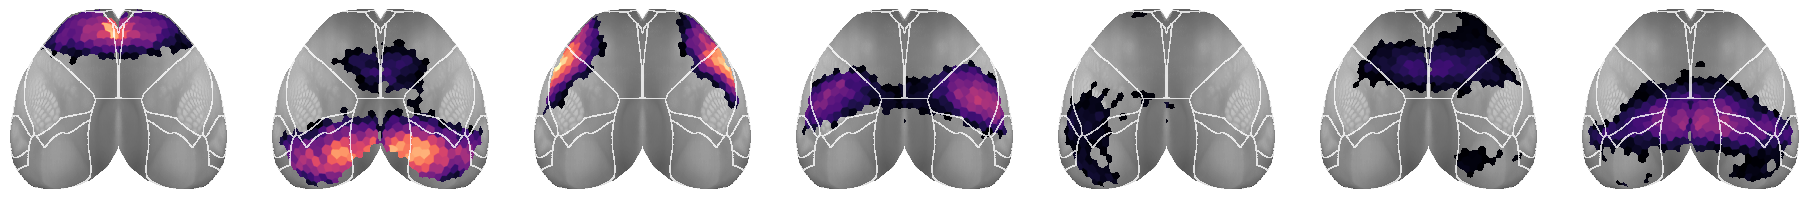

In [104]:
_ = self.show(pi_dki, vmin=0.15, vmax=0.35, mask_thresh=0.15)

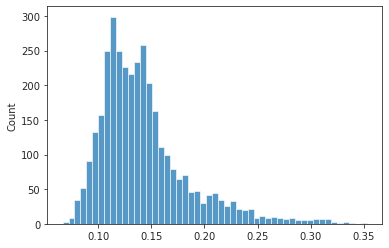

In [105]:
sns.histplot(pi_dki.ravel());

### WT

In [106]:
data = np.concatenate([x.reshape(-1, len(self.n2l)) for x in gam_all['WT']])
data.shape

(437472, 532)

In [107]:
nonan = np.where(np.isnan(data).sum(0) == 0)[0]
len(nonan)

457

In [108]:
%%time

centroids = np.zeros((self.num_k, data.shape[-1]))
_centroids, _ = fit_kmeans(
    data=data[:, nonan],
    n_clusters=self.num_k,
    match_metric=self.sv_props['match_metric'],
    random_state=self.mice.cfg.random_state,
    kw_kmeans=self.kw_kmeans,
)
centroids = np.zeros((self.num_k, data.shape[-1]))
centroids[:, nonan] = _centroids

CPU times: user 1h 9min 16s, sys: 38.8 s, total: 1h 9min 55s
Wall time: 1min 57s


In [109]:
global_mapping = self.align_centroid_to_structs(
    pi_mv=centroids,
    metric='cosine',
    global_order=False,
)
centroids = centroids[global_mapping]
ner = Normalizer()

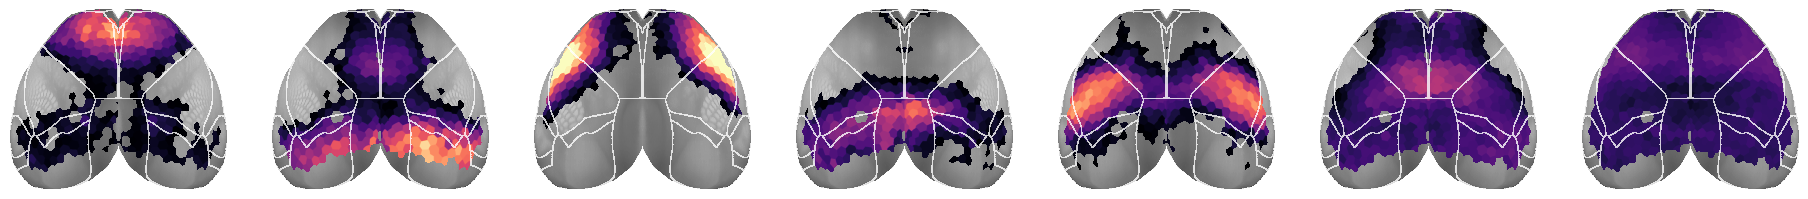

In [110]:
pi = centroids / np.nansum(centroids, -2, keepdims=True)
_ = self.show(pi, vmin=0.1, vmax=0.4, mask_thresh=0.1)

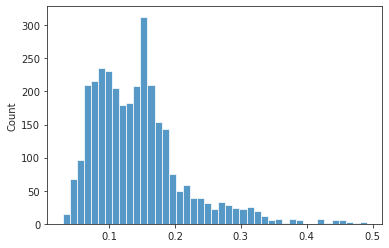

In [111]:
sns.histplot(pi.ravel());

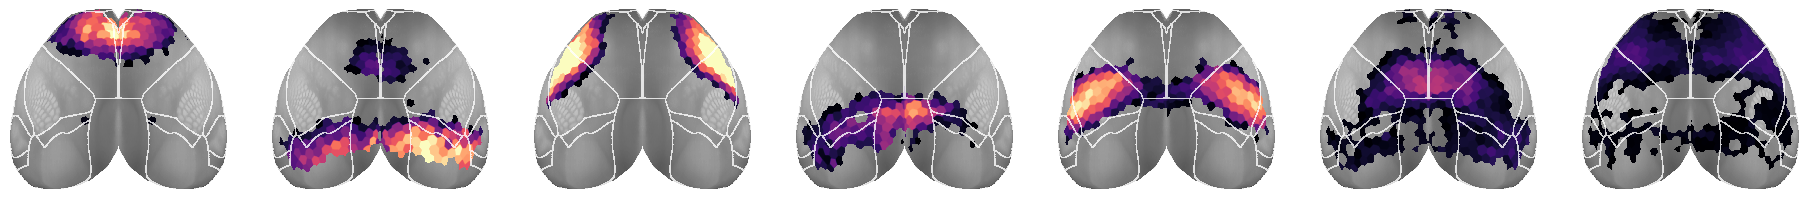

In [112]:
_ = self.show(pi, vmin=0.15, vmax=0.35, mask_thresh=0.15)

In [113]:
%%time

final = []
for f in tqdm(sorted(os.listdir(mice.cfg.svinet_dir))):
    key = '_'.join(f.split('_')[-3:])
    if 'pearson' in key:
        continue
    g = re.findall(
        r"[a-zA-Z]+",
        key.split('_')[0].split('-')[1],
    ).pop()
    if g != 'WT':
        continue
    sv = SVINET(
        key=key,
        **kwargs,
    ).load_results()
    
    good = np.where(np.isnan(sv.gam).sum(0) == 0)[0]
    good = set(good).intersection(nonan)
    good = np.array(sorted(good))
    _x = sv.gam_all[..., good]
    _x = np.where(~np.isnan(_x), _x, 0.0)
    data_clean = {
        i: ner.fit_transform(_x[i])
        for i in range(len(_x))
    }
    perms =  find_best_mappings(
        data=data_clean,
        centroids=ner.fit_transform(centroids[:, good]),
        match_metric=self.align_metric,
        global_order=self.global_order,
    )
    x = np_nans(sv.gam_all.shape)
    for seed, p in perms.items():
        x[seed] = sv.gam_all[seed][list(p.values())]
    final.append(np.expand_dims(avg(x), 0))
final = np.concatenate(final)
final.shape

  0%|          | 0/350 [00:00<?, ?it/s]

CPU times: user 45.4 s, sys: 272 ms, total: 45.7 s
Wall time: 45.7 s


(125, 7, 532)

In [114]:
pi_wt = avg(final)
pi_wt /= np.nansum(pi_wt, -2, keepdims=True)
pi_wt.shape

(7, 532)

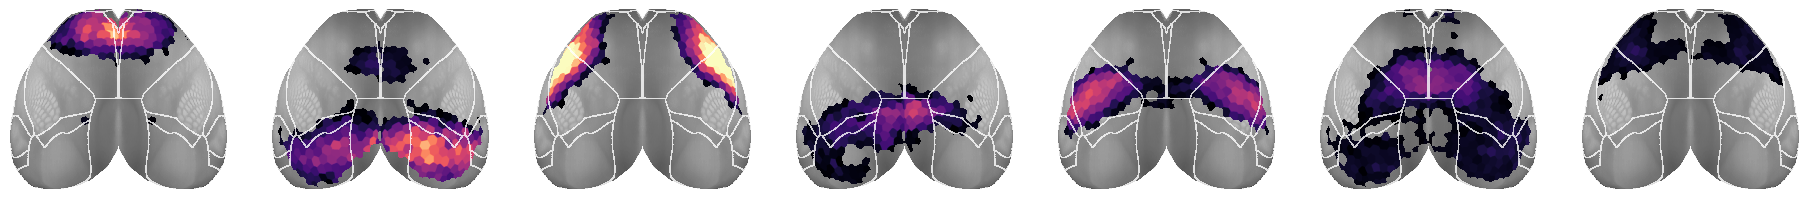

In [115]:
_ = self.show(pi_wt, vmin=0.15, vmax=0.35, mask_thresh=0.15)

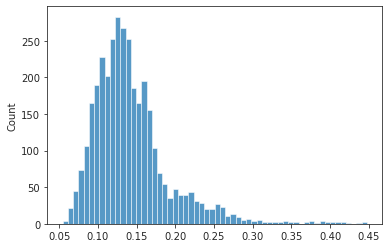

In [116]:
sns.histplot(pi_wt.ravel());

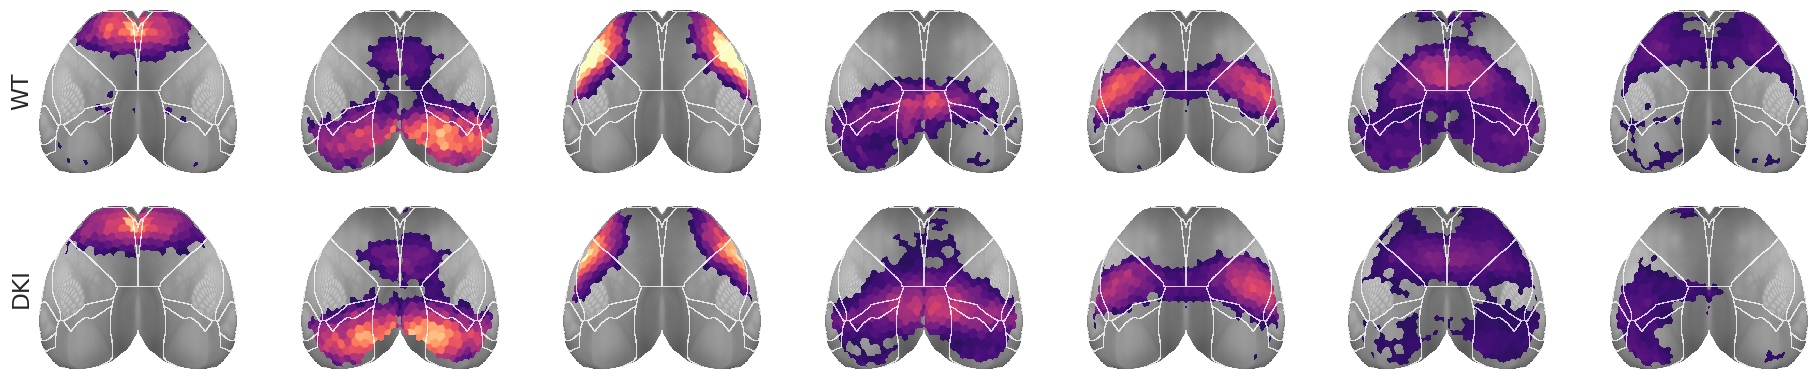

In [124]:
_ = self.show({
    'WT': pi_wt[[0, 1, 2, 3, 4, 5, 6]],
    'DKI': pi_dki[[0, 1, 2, 6, 3, 5, 4]]},
    vmin=0.1,
    vmax=0.35,
    mask_thresh=0.14,
)

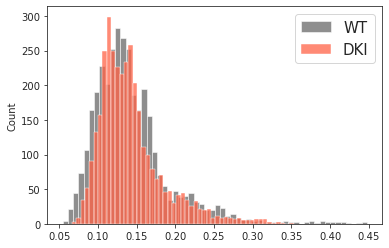

In [122]:
sns.histplot(pi_wt.ravel(), color='dimgrey', label='WT')
sns.histplot(pi_dki.ravel(), color='tomato', label='DKI')
plt.legend(fontsize=15);

In [241]:
collections.Counter([v.shape for v in gam_all['DKI']])

Counter({(1, 500, 7, 532): 218, (1, 499, 7, 532): 5})

## SVINET (k=6)

In [158]:
cnt = []
for f in sorted(os.listdir(mice.cfg.svinet_dir)):
    files = pjoin(mice.cfg.svinet_dir, f, 'real', 'p15-sample')
    files = sorted(os.listdir(files))
    cnt.append(len(files) - 1)
cnt = collections.Counter(cnt)
cnt

Counter({1000: 350})

In [159]:
num_k = 6
kwargs = {
    'mice': mice,
    'num_k': num_k,
    'perc': 'p15-sample',
    'mode': 'bold-lite',
    'verbpose': True,
}

In [160]:
%%time

for f in tqdm(sorted(os.listdir(mice.cfg.svinet_dir))):
    key = '_'.join(f.split('_')[-3:])
    if 'pearson' in key:
        continue
    sv = SVINET(key=key, **kwargs)
    sv.n2l = {
        n: '-'.join(map(
            lambda x: str(x),
            mice.parcel.decode(r).ravel()
        )) for n, r in node2region.items()
    }
    _ = sv.load_runs()
    _ = sv.fit_svinet()

  0%|          | 0/350 [00:00<?, ?it/s]

CPU times: user 1h 53min 16s, sys: 3min 11s, total: 1h 56min 27s
Wall time: 47min 26s


In [161]:
%%time

gam_all = collections.defaultdict(list)
for f in sorted(os.listdir(mice.cfg.svinet_dir)):
    key = '_'.join(f.split('_')[-3:])
    if 'pearson' in key:
        continue
    sv = SVINET(
        key=key,
        **kwargs,
    ).load_results()
    
    g = re.findall(
        r"[a-zA-Z]+",
        key.split('_')[0].split('-')[1],
    ).pop()
    gam_all[g].append(sv.gam_all)

CPU times: user 38.2 s, sys: 476 ms, total: 38.7 s
Wall time: 38.7 s


In [162]:
props = {
    'mice': mice,
    'perc': 'p15-sample',
    'num_k': num_k,
    'mode': 'bold-lite',
    'task': 'rest',
    'metric': 'pearson',
    'match_metric': 'euclidean',
    'match_using': 'gam',
    'graph_type': 'real',
    'dist_metric': 'cosine',
    'ordering': 'infer',
    'verbose': True,
}
self = Group(**props)
self.kw_kmeans = {'n_init': 10, 'max_iter': 300, 'tol': 0.0001}
self.n2l = {
    n: '-'.join(map(
        lambda x: str(x),
        mice.parcel.decode(r).ravel()
    )) for n, r in node2region.items()
}

### DKI

In [163]:
data = np.concatenate([x.reshape(-1, len(self.n2l)) for x in gam_all['DKI']])
data.shape

(668934, 532)

In [164]:
nonan = np.where(np.isnan(data).sum(0) == 0)[0]
len(nonan)

473

In [165]:
%%time

centroids = np.zeros((self.num_k, data.shape[-1]))
_centroids, _ = fit_kmeans(
    data=data[:, nonan],
    n_clusters=self.num_k,
    match_metric=self.sv_props['match_metric'],
    random_state=self.mice.cfg.random_state,
    kw_kmeans=self.kw_kmeans,
)
centroids = np.zeros((self.num_k, data.shape[-1]))
centroids[:, nonan] = _centroids

CPU times: user 50min 36s, sys: 16.1 s, total: 50min 52s
Wall time: 2min 44s


In [166]:
global_mapping = self.align_centroid_to_structs(
    pi_mv=centroids,
    metric='cosine',
    global_order=False,
)
centroids = centroids[global_mapping]
ner = Normalizer()

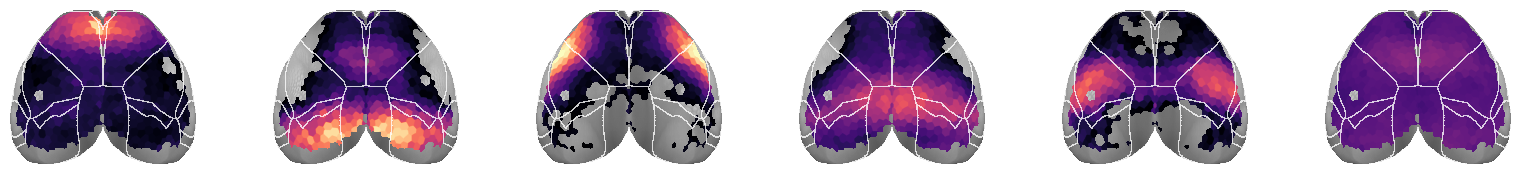

In [167]:
pi = centroids / np.nansum(centroids, -2, keepdims=True)
_ = self.show(pi, vmin=0.1, vmax=0.4, mask_thresh=0.1)

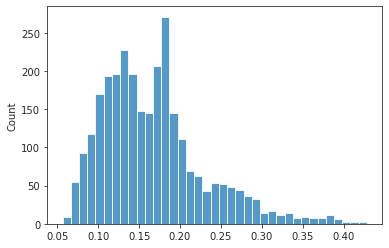

In [168]:
sns.histplot(pi.ravel());

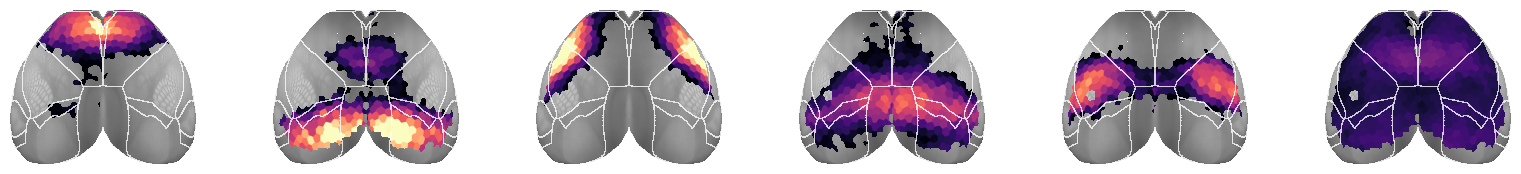

In [169]:
_ = self.show(pi, vmin=0.15, vmax=0.35, mask_thresh=0.15)

In [170]:
%%time

final = []
for f in tqdm(sorted(os.listdir(mice.cfg.svinet_dir))):
    key = '_'.join(f.split('_')[-3:])
    if 'pearson' in key:
        continue
    g = re.findall(
        r"[a-zA-Z]+",
        key.split('_')[0].split('-')[1],
    ).pop()
    if g != 'DKI':
        continue
    sv = SVINET(
        key=key,
        **kwargs,
    ).load_results()
    
    good = np.where(np.isnan(sv.gam).sum(0) == 0)[0]
    good = set(good).intersection(nonan)
    good = np.array(sorted(good))
    _x = sv.gam_all[..., good]
    _x = np.where(~np.isnan(_x), _x, 0.0)
    data_clean = {
        i: ner.fit_transform(_x[i])
        for i in range(len(_x))
    }
    perms =  find_best_mappings(
        data=data_clean,
        centroids=ner.fit_transform(centroids[:, good]),
        match_metric=self.align_metric,
        global_order=self.global_order,
    )
    x = np_nans(sv.gam_all.shape)
    for seed, p in perms.items():
        x[seed] = sv.gam_all[seed][list(p.values())]
    final.append(np.expand_dims(avg(x), 0))
final = np.concatenate(final)
final.shape

  0%|          | 0/350 [00:00<?, ?it/s]

CPU times: user 1min 19s, sys: 840 ms, total: 1min 20s
Wall time: 1min 19s


(223, 6, 532)

In [171]:
pi_dki = avg(final)
pi_dki /= np.nansum(pi_dki, -2, keepdims=True)
pi_dki.shape

(6, 532)

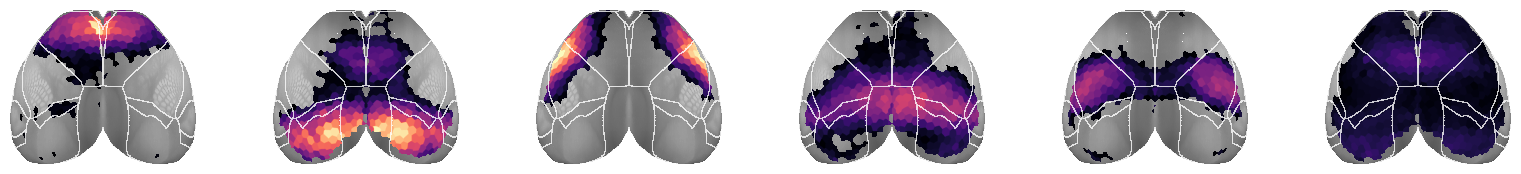

In [172]:
_ = self.show(pi_dki, vmin=0.15, vmax=0.35, mask_thresh=0.15)

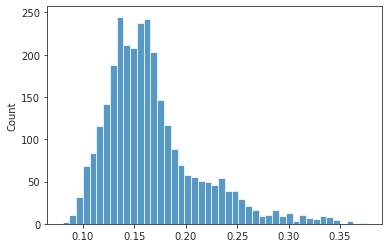

In [173]:
sns.histplot(pi_dki.ravel());

### WT

In [174]:
data = np.concatenate([x.reshape(-1, len(self.n2l)) for x in gam_all['WT']])
data.shape

(374958, 532)

In [175]:
nonan = np.where(np.isnan(data).sum(0) == 0)[0]
len(nonan)

457

In [176]:
%%time

centroids = np.zeros((self.num_k, data.shape[-1]))
_centroids, _ = fit_kmeans(
    data=data[:, nonan],
    n_clusters=self.num_k,
    match_metric=self.sv_props['match_metric'],
    random_state=self.mice.cfg.random_state,
    kw_kmeans=self.kw_kmeans,
)
centroids = np.zeros((self.num_k, data.shape[-1]))
centroids[:, nonan] = _centroids

CPU times: user 17min 31s, sys: 6.85 s, total: 17min 38s
Wall time: 58.8 s


In [177]:
global_mapping = self.align_centroid_to_structs(
    pi_mv=centroids,
    metric='cosine',
    global_order=False,
)
centroids = centroids[global_mapping]
ner = Normalizer()

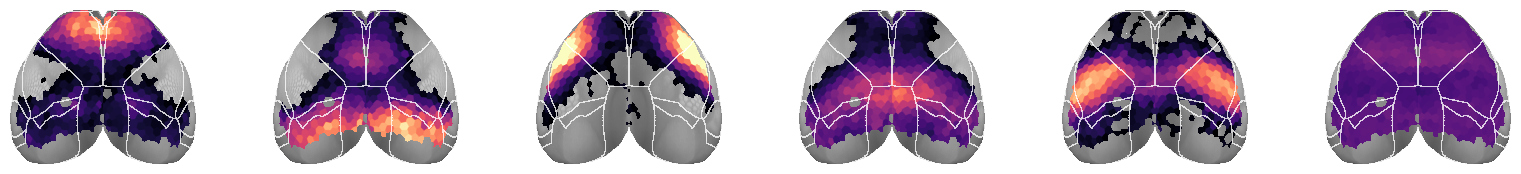

In [178]:
pi = centroids / np.nansum(centroids, -2, keepdims=True)
_ = self.show(pi, vmin=0.1, vmax=0.4, mask_thresh=0.1)

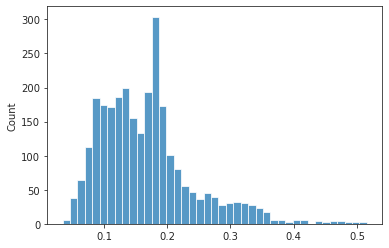

In [179]:
sns.histplot(pi.ravel());

In [ ]:
_ = self.show(pi, vmin=0.15, vmax=0.35, mask_thresh=0.15)

In [181]:
%%time

final = []
for f in tqdm(sorted(os.listdir(mice.cfg.svinet_dir))):
    key = '_'.join(f.split('_')[-3:])
    if 'pearson' in key:
        continue
    g = re.findall(
        r"[a-zA-Z]+",
        key.split('_')[0].split('-')[1],
    ).pop()
    if g != 'WT':
        continue
    sv = SVINET(
        key=key,
        **kwargs,
    ).load_results()
    
    good = np.where(np.isnan(sv.gam).sum(0) == 0)[0]
    good = set(good).intersection(nonan)
    good = np.array(sorted(good))
    _x = sv.gam_all[..., good]
    _x = np.where(~np.isnan(_x), _x, 0.0)
    data_clean = {
        i: ner.fit_transform(_x[i])
        for i in range(len(_x))
    }
    perms =  find_best_mappings(
        data=data_clean,
        centroids=ner.fit_transform(centroids[:, good]),
        match_metric=self.align_metric,
        global_order=self.global_order,
    )
    x = np_nans(sv.gam_all.shape)
    for seed, p in perms.items():
        x[seed] = sv.gam_all[seed][list(p.values())]
    final.append(np.expand_dims(avg(x), 0))
final = np.concatenate(final)
final.shape

CPU times: user 45.7 s, sys: 376 ms, total: 46 s
Wall time: 46 s


(125, 6, 532)

In [182]:
pi_wt = avg(final)
pi_wt /= np.nansum(pi_wt, -2, keepdims=True)
pi_wt.shape

(6, 532)

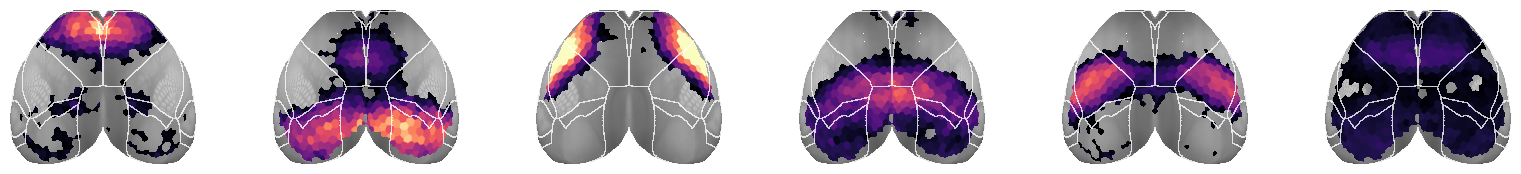

In [183]:
_ = self.show(pi_wt, vmin=0.15, vmax=0.35, mask_thresh=0.15)

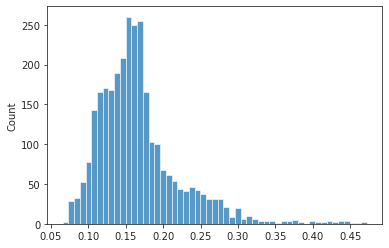

In [184]:
sns.histplot(pi_wt.ravel());

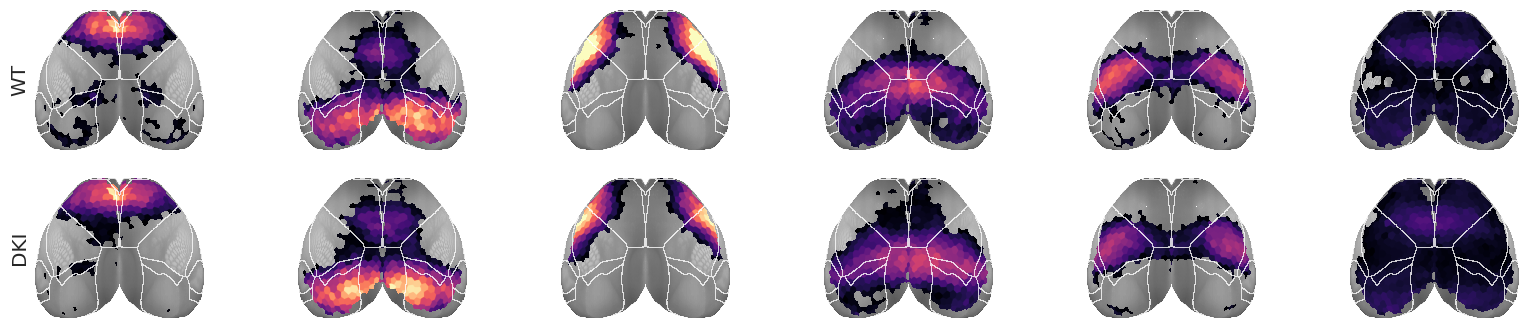

In [191]:
_ = self.show({
    'WT': pi_wt,
    'DKI': pi_dki},
    vmin=0.15,
    vmax=0.35,
    mask_thresh=0.15,
)

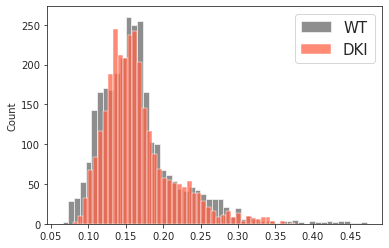

In [187]:
sns.histplot(pi_wt.ravel(), color='dimgrey', label='WT')
sns.histplot(pi_dki.ravel(), color='tomato', label='DKI')
plt.legend(fontsize=15);